Import all necessary libraries, upload the dataset, and load it into a pandas DataFrame.

In [1]:
# 1. Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from datetime import datetime
import math

Loading the Dataset: The DataFrame df is created by reading the CSV file. Confirm that the file name matches your dataset.

In [2]:

# Upload dataset
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('freight_consolidation_dataset.csv')

Saving freight_consolidation_dataset.csv to freight_consolidation_dataset.csv


Clean the dataset and prepare it for analysis.
`A print statement outputs all current column names. Ensure that all expected columns are present before proceeding.`

In [ ]:
# 2. Data Preprocessing
# Handle missing values
print("Missing values before handling:\n", df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)  # Numeric columns
df.fillna(df.mode().iloc[0], inplace=True)  # Categorical columns

# Convert Delivery_Deadline to datetime
df['Delivery_Deadline'] = pd.to_datetime(df['Delivery_Deadline'])

# Identify numerical and categorical columns
numerical_cols = ['Pickup_Latitude', 'Pickup_Longitude', 'Delivery_Latitude',
                  'Delivery_Longitude', 'Distance_km', 'Estimated_Travel_Time_h',
                  'Fuel_Cost_per_km', 'Vehicle_Capacity_kg', 'Vehicle_Capacity_m3']

categorical_cols = ['Delivery_Priority', 'Vehicle_Type', 'Route_Type',
                    'Special_Requirements', 'Urgency_Level', 'Packaging_Type',
                    'Border_Crossing_Fee', 'Weather_Impact', 'Region']

# Verify columns exist
print("Columns before feature engineering:", df.columns.tolist())

Create a new target variable, Total_Cost, by summing Fuel_Cost, Fixed_Cost, and Variable_Cost. Compute additional features such as the Haversine distance (calculating real-world distance between points) and extract time-based features from Delivery_Deadline. Remove the original cost fields post-calculation to avoid redundancy.

In [4]:
# 3. Feature Engineering
# Create Total_Cost target variable
df['Total_Cost'] = df['Fuel_Cost_per_km.1'] + df['Fixed_Cost_per_Shipment'] + df['Variable_Cost_per_km']

# Create Haversine distance feature
def haversine_distance(row):
    lat1, lon1 = row['Pickup_Latitude'], row['Pickup_Longitude']
    lat2, lon2 = row['Delivery_Latitude'], row['Delivery_Longitude']
    R = 6371  # Earth radius in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

df['Haversine_Distance'] = df.apply(haversine_distance, axis=1)

# Create time-related features from Delivery_Deadline
df['Deadline_Hour'] = df['Delivery_Deadline'].dt.hour
df['Deadline_Day'] = df['Delivery_Deadline'].dt.dayofweek

# Drop original cost columns and unnecessary features
df.drop(['Fuel_Cost_per_km.1', 'Fixed_Cost_per_Shipment', 'Variable_Cost_per_km'], axis=1, inplace=True)

# Verify columns after feature engineering
print("\nColumns after feature engineering:", df.columns.tolist())
# Check if ALL specified columns are present before proceeding
missing_cols = [col for col in numerical_cols + categorical_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"The following columns are missing: {missing_cols}")

# Check if Fuel_Cost_per_km is still present
if 'Fuel_Cost_per_km' not in df.columns:
    raise ValueError("Fuel_Cost_per_km column is missing after feature engineering")


Columns after feature engineering: ['Shipment_ID', 'Weight_kg', 'Volume_m3', 'Pickup_Latitude', 'Pickup_Longitude', 'Delivery_Latitude', 'Delivery_Longitude', 'Delivery_Priority', 'Vehicle_Capacity_kg', 'Vehicle_Capacity_m3', 'Fuel_Cost_per_km', 'Vehicle_Type', 'Distance_km', 'Estimated_Travel_Time_h', 'Route_Type', 'Delivery_Deadline', 'Special_Requirements', 'Urgency_Level', 'Packaging_Type', 'Border_Crossing_Fee', 'Weather_Impact', 'Region', 'Total_Cost', 'Haversine_Distance', 'Deadline_Hour', 'Deadline_Day']


Separate dataset into features (X) and target (y), then perform a split into training (70%), validation (15%), and test (15%) datasets to prepare for unbiased model evaluation and hyperparameter tuning.

In [5]:
# 4. Data Splitting
X = df.drop('Total_Cost', axis=1)
y = df['Total_Cost']

# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Construct separate preprocessing pipelines for numerical and categorical data using imputation, scaling, and encoding methods. Use a ColumnTransformer to combine these pipelines and then integrate them into a full ML pipeline with a Gradient Boosting Regressor to predict Total_Cost.

In [6]:
# 5. Model Pipeline and Selection
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Complete pipeline with Gradient Boosting Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))])

Define a grid of hyperparameters for the Gradient Boosting Regressor, then use GridSearchCV to train the model with cross-validation on the training set. Identify and extract the best performing model from the search process.

In [7]:
# 6. Model Training and Hyperparameter Tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.1, 0.05],
    'regressor__max_depth': [3, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Evaluate the tuned model on the validation and test sets using regression metrics such as MAE, RMSE, and R². Generate scatter plots (predicted vs. actual) and histogram plots of residuals to visually assess the model’s prediction performance.

Validation Set:
MAE: 64.06
RMSE: 73.53
R²: -0.00

Test Set:
MAE: 63.69
RMSE: 73.57
R²: -0.01


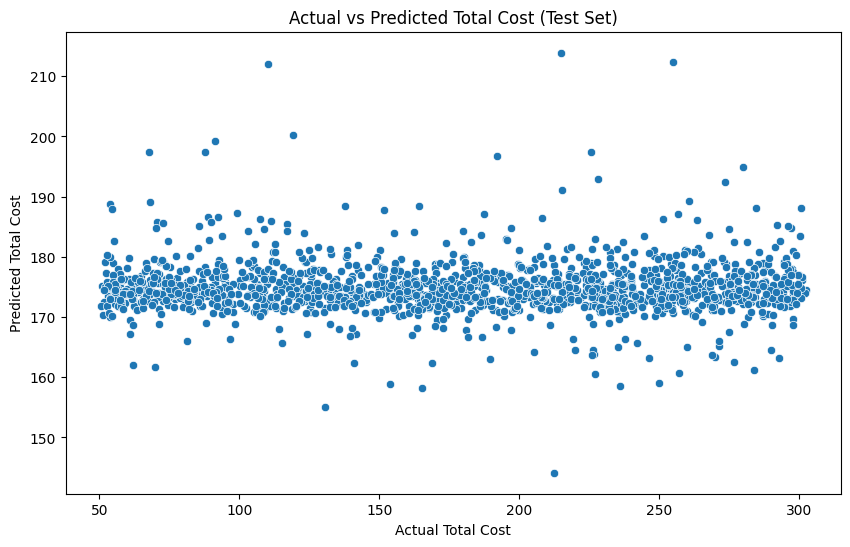

In [11]:
# 7. Model Evaluation
"""
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    return mae, rmse, r2
"""
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    # Calculate RMSE without the 'squared' argument
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return mae, rmse, r2
# Validation set evaluation
val_mae, val_rmse, val_r2 = evaluate_model(best_model, X_val, y_val)
print(f"Validation Set:\nMAE: {val_mae:.2f}\nRMSE: {val_rmse:.2f}\nR²: {val_r2:.2f}\n")

# Test set evaluation
test_mae, test_rmse, test_r2 = evaluate_model(best_model, X_test, y_test)
print(f"Test Set:\nMAE: {test_mae:.2f}\nRMSE: {test_rmse:.2f}\nR²: {test_r2:.2f}")
"""
# Visualizations
plt.figure(figsize=(10, 6))
sns.scatterplot(y_test, best_model.predict(X_test))
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Total Cost (Test Set)")
plt.show()

residuals = y_test - best_model.predict(X_test)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
"""
# Visualizations
plt.figure(figsize=(10, 6))
# Using the 'x' and 'y' arguments to specify columns within a DataFrame:
sns.scatterplot(x=y_test, y=best_model.predict(X_test))
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Total Cost (Test Set)")
plt.show()

Serialize (save) the final model using joblib for future use or integration into a real-time system. A sample prediction is also demonstrated to show how the model can be used to generate output from new input data

In [12]:
# 8. Model Deployment
joblib.dump(best_model, 'freight_optimizer_model.joblib')

# Example usage
sample_data = X_test.iloc[[0]]
prediction = best_model.predict(sample_data)
print(f"\nSample Prediction: {prediction[0]:.2f}")
print(f"Actual Value: {y_test.iloc[0]:.2f}")


Sample Prediction: 179.82
Actual Value: 60.54


In [ ]:
loaded_model = joblib.load('freight_optimizer_model.joblib')
new_predictions = loaded_model.predict('freight_consolidation_dataset.csv')